In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [69]:
df = pd.read_csv('data/housing.csv')
len(df)

20640

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploratory data analysis

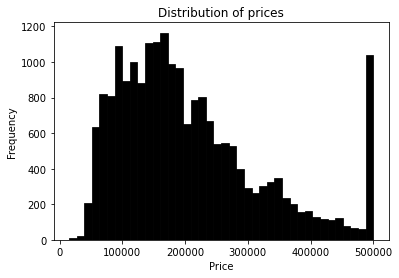

In [5]:
plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

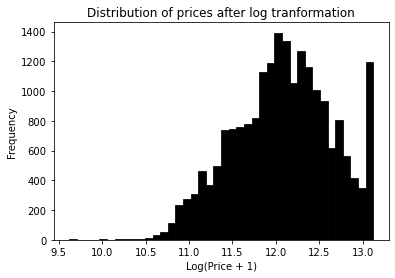

In [6]:
log_price = np.log1p(df.median_house_value)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

# Question 1

In [8]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

# Question 2

In [9]:
df['population'].median()

1166.0

# Split the data

In [11]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test


idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [12]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# Question 3

## Linear Regression

In [13]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [14]:
#selected columns
base = ['longitude', 'latitude', 'housing_median_age', 
        'total_rooms','total_bedrooms', 'population', 
        'households', 'median_income']

In [15]:
def prepare_X(df, n):
    '''Add n for different deal with missing values '''
    df_num = df[base]
    df_num = df_num.fillna(n)
    X = df_num.values
    return X

## Fill na values with 0

In [16]:
X_train = prepare_X(df_train, 0)
w_0, w = train_linear_regression(X_train, y_train)

In [17]:
y_pred = w_0 + X_train.dot(w)

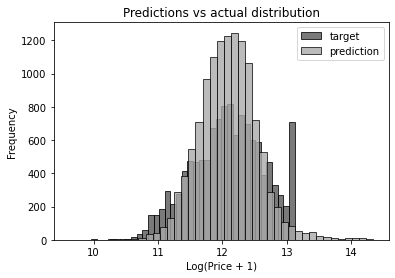

In [18]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [19]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [20]:
rmse(y_train, y_pred)

0.3413135910156675

In [22]:
X_val = prepare_X(df_val,0)
y_pred = w_0 + X_val.dot(w)

In [25]:
score = rmse(y_val, y_pred)
score_0 = round(score, 2)
score_0

0.33

## Fill na values with mean

In [29]:
total_bedrooms_mean = df_train['total_bedrooms'].mean()

In [30]:
X_train = prepare_X(df_train, total_bedrooms_mean)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

In [32]:
rmse(y_train, y_pred)

0.3410416181032806

In [33]:
X_val = prepare_X(df_val,total_bedrooms_mean)
y_pred = w_0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score_mean = round(score, 2)
score_mean

0.33

## Fill na values with median

In [36]:
total_bedrooms_median = df_train['total_bedrooms'].median()
X_train = prepare_X(df_train, total_bedrooms_median)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
rmse(y_train, y_pred)

0.3410609087581672

In [37]:
X_val = prepare_X(df_val,total_bedrooms_median)
y_pred = w_0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score_median = round(score, 2)
score_median

0.33

In [38]:
score_0, score_mean, score_median

(0.33, 0.33, 0.33)

# Question 4

In [39]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [40]:
X_train = prepare_X(df_train, 0)

In [60]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_val = prepare_X(df_val, 0)
    y_pred = w_0 + X_val.dot(w)

    score = rmse(y_val, y_pred)
    
    print(f'r: {r:10} \t w0: {round(w_0,3):10} score:{round(score,2)}')

r:          0 	 w0:    -11.687 score:0.33
r:      1e-06 	 w0:    -11.687 score:0.33
r:     0.0001 	 w0:    -11.685 score:0.33
r:      0.001 	 w0:    -11.671 score:0.33
r:       0.01 	 w0:    -11.528 score:0.33
r:        0.1 	 w0:    -10.275 score:0.33
r:          1 	 w0:      -4.92 score:0.33
r:          5 	 w0:     -1.482 score:0.34
r:         10 	 w0:      -0.79 score:0.34


# Question 5

In [72]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

In [73]:
def split_data(seed):
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [74]:
for s in seeds:    
    df_train, df_val, df_test, y_train, y_val, y_test = split_data(s)
    
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X(df_val,0)
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)
   
    scores.append(round(score, 2))
    
print(scores)

[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]


In [75]:
std = np.std(scores)
round(std, 3)

0.005

# Question 6

In [81]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(9)

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X(df_full_train, 0)

y_full_train = np.concatenate([y_train, y_val])
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)
    
X_test = prepare_X(df_test,0)
y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred)
round(score,2)

0.35